In [82]:
# Dependencies 
# !pip3 install torch torchvision torchaudio
# !pip3 install nuscenes-devkit

In [83]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
from PIL import Image
import torch.nn.functional as F
from IPython.display import Image as IPImage
from scipy import misc

In [84]:
from nuscenes.can_bus.can_bus_api import NuScenesCanBus
from nuscenes.nuscenes import NuScenes
PATH = '/Users/jonathanmorris/Downloads/v1.0-mini'

nusc = NuScenes(version='v1.0-mini', dataroot=PATH, verbose=True)
nusc_can = NuScenesCanBus(dataroot=PATH)
HEIGHT = 70
WIDTH = 320

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.361 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [85]:
def get_closest_can(time, can_objects):
    closest = {}
    prev_diff = 1000000 # 1 Second in microseconds
    for object in can_objects:
        diff = object["utime"] - time
        if diff > 0 and diff < prev_diff:
            closest = object
            prev_diff = diff
    # print("Time difference: ", prev_diff)
    return closest

def num_to_range(num, inMin, inMax, outMin, outMax):
    return outMin + (float(num - inMin) / float(inMax - inMin) * (outMax - outMin))

def normalize_vehicle_monitor_can(can_obj):
    new_obj = {}

    min_brake = 0
    max_break = 126

    min_steering = -780
    max_steering = 779.9

    min_throttle = 0
    max_throttle = 1000

    new_obj["brake"] = num_to_range(can_obj["brake"], min_brake, max_break, 0, 1)
    new_obj["steering"] = num_to_range(can_obj["steering"], min_steering, max_steering, -1, 1)
    new_obj["throttle"] = num_to_range(can_obj["throttle"], min_throttle, max_throttle, 0, 1)

    new_obj["brake"] = round(new_obj["brake"], 1)
    new_obj["steering"] = round(new_obj["steering"], 1)
    new_obj["throttle"] = round(new_obj["throttle"], 1)

    return new_obj

In [102]:
class NuScenesImageDataset(Dataset):
    """The training table dataset.
    """
    def __init__(self, nusc, nusc_can, transform=None):
        self.nusc = nusc
        self.nusc_can = nusc_can
        self.transform = transform
        self.x_image_data = []
        self.y_vehicle_data = []
        self.len = len(nusc.scene)

        for scene in nusc.scene:
            scene_number = int(scene['name'].split("-")[1])
            if scene_number in nusc_can.can_blacklist:
                print("Skipping scene " + str(scene_number))
                continue

            scene_token = scene['token']
            scene_record = nusc.get('scene', scene_token)
            sample_token = scene_record['first_sample_token']
            
            while sample_token != '':
                sample_record = nusc.get('sample', sample_token)
                sample_data = nusc.get('sample_data', sample_record['data']["CAM_FRONT"])

                image_path = nusc.get_sample_data_path(sample_data['token'])
                image = Image.open(image_path)
                image = transform(image)                

                can_objects = nusc_can.get_messages(scene['name'], 'vehicle_monitor')
                closest_can = get_closest_can(sample_data['timestamp'], can_objects)

                if closest_can == {}:
                    print("CAN Not Close enough")
                    break

                normal_vm_can = normalize_vehicle_monitor_can(closest_can)

                steering_targets = normal_vm_can['steering']
                throttle_targets = normal_vm_can['throttle']
                breaking_targets = normal_vm_can['brake']

                label = torch.FloatTensor([steering_targets, throttle_targets, breaking_targets])

                self.x_image_data.append(image)
                self.y_vehicle_data.append(label)

                sample_token = sample_record['next']
        
    def __getitem__(self, index):
        return self.x_image_data[index], self.y_vehicle_data[index]
        
    def __len__(self):
        return self.len

In [103]:
# https://github.com/Zhenye-Na/e2e-learning-self-driving-cars/blob/master/src/train.ipynb

class NetworkNvidia(nn.Module):
    """NVIDIA model used in the paper."""

    def __init__(self):
        """Initialize NVIDIA model.

        NVIDIA model used
            Image normalization to avoid saturation and make gradients work better.
            Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Drop out (0.5)
            Fully connected: neurons: 100, activation: ELU
            Fully connected: neurons: 50, activation: ELU
            Fully connected: neurons: 10, activation: ELU
            Fully connected: neurons: 1 (output)

        the convolution layers are meant to handle feature engineering
        the fully connected layer for predicting the steering angle.
        """
        super(NetworkNvidia, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64 * 2 * 33, out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=3)
        )

    def forward(self, input):
        """Forward pass."""
        input = input.view(input.size(0), 3, HEIGHT, WIDTH)
        output = self.conv_layers(input)
        # print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

In [104]:
learning_rate = 0.001
batch_size = 1
epochs = 200
model_path = os.path.join(os.getcwd(), "models")

!mkdir models && cd models && mkdir epochs

print(model_path)
transform = transforms.Compose(
        [transforms.Resize((70, 320), antialias=True), transforms.ToTensor()]
    )
model_number = "1.2"
model_file_name = f"nuscenes_model_v{model_number}.pth"

mkdir: models: File exists


/Users/jonathanmorris/Developer/cruz-control/nuscenes/lane_following/models


In [105]:
dataset = NuScenesImageDataset(nusc, nusc_can, transform)

In [90]:
def train():
    print(f"Model Version v{model_number}")
    print("final model weights will be saved to: " + model_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "mps")

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train, val = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)

    net = NetworkNvidia().to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    print(f"Training on {device}")
    for epoch in range(epochs):
            net.train()
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # Forward pass
                
                # input_update = inputs.unsqueeze(0).to(device)

                prediction = net(inputs)

                # Compute loss
                value_loss = criterion(prediction, labels)

                # Backward pass
                value_loss.backward()

                # Update weights
                optimizer.step()

            # Validation
            net.eval()
            with torch.no_grad():
                for val_inputs, labels in val_loader:
                    val_inputs = val_inputs.to(device)  # Move validation data to GPU
                    labels = labels.to(device)

                    # input_update = val_inputs.unsqueeze(0).to(device)
                    prediction = net(val_inputs)
                    total_val_loss = criterion(prediction, labels)

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {value_loss.item():.4f}, Validation Loss: {total_val_loss.item():.4f}')
            torch.save(net.state_dict(), os.path.join(model_path, "epochs", f"model_e{epoch+1}.pth"))


    print("Finished training")
    torch.save(net.state_dict(), os.path.join(model_path, model_file_name))

In [91]:
train()

Model Version v1.2
final model weights will be saved to: /Users/jonathanmorris/Developer/cruz-control/nuscenes/lane_following/models
Training on mps
Epoch 1/200, Loss: 0.0021, Validation Loss: 0.0017
Epoch 2/200, Loss: 0.0003, Validation Loss: 0.0006
Epoch 3/200, Loss: 0.0002, Validation Loss: 0.0002
Epoch 4/200, Loss: 0.0007, Validation Loss: 0.0005
Epoch 5/200, Loss: 0.0011, Validation Loss: 0.0015
Epoch 6/200, Loss: 0.0002, Validation Loss: 0.0011
Epoch 7/200, Loss: 0.0003, Validation Loss: 0.0005
Epoch 8/200, Loss: 0.0001, Validation Loss: 0.0002
Epoch 9/200, Loss: 0.0001, Validation Loss: 0.0004
Epoch 10/200, Loss: 0.0012, Validation Loss: 0.0004
Epoch 11/200, Loss: 0.0000, Validation Loss: 0.0001
Epoch 12/200, Loss: 0.0002, Validation Loss: 0.0004
Epoch 13/200, Loss: 0.0002, Validation Loss: 0.0002
Epoch 14/200, Loss: 0.0001, Validation Loss: 0.0000
Epoch 15/200, Loss: 0.0002, Validation Loss: 0.0001
Epoch 16/200, Loss: 0.0001, Validation Loss: 0.0001
Epoch 17/200, Loss: 0.0002, 

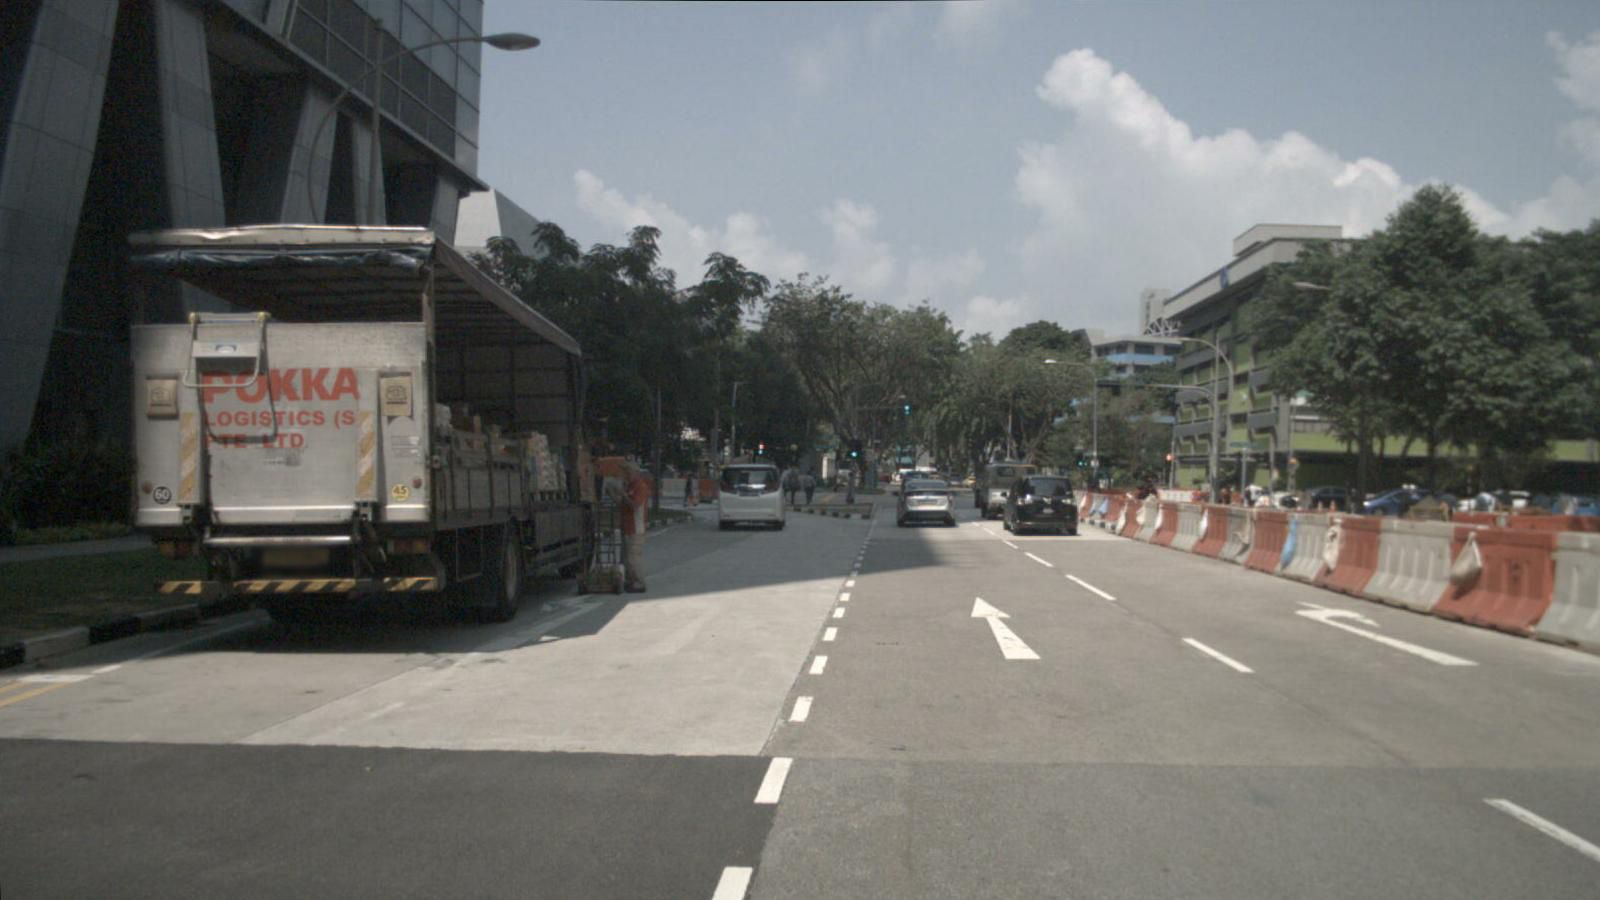

In [92]:
my_scene = nusc.scene[0]
my_scene_vehicle_monitor_can = nusc_can.get_messages(my_scene['name'], 'vehicle_monitor')
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
current_image_path = PATH+"/"+cam_front_data['filename']
img = Image.open(current_image_path)
image_tensor = transform(img)
image_tensor = image_tensor.view(1, 3, 70, 320)
IPImage(filename=current_image_path) 

In [93]:
os.path.join(model_path, model_file_name)

'/Users/jonathanmorris/Developer/cruz-control/nuscenes/lane_following/models/nuscenes_model_v1.2.pth'

In [94]:
closest_can = get_closest_can(my_sample['timestamp'], my_scene_vehicle_monitor_can)
normalize_vehicle_monitor_can(closest_can)

{'brake': 0.0, 'steering': 0.0, 'throttle': 0.0}

In [95]:
model = NetworkNvidia()
model.load_state_dict(torch.load(model_path + "/" + model_file_name, map_location=torch.device('mps')))
model.eval()
model(image_tensor)

tensor([[-0.0102,  0.0036, -0.0055]], grad_fn=<AddmmBackward0>)

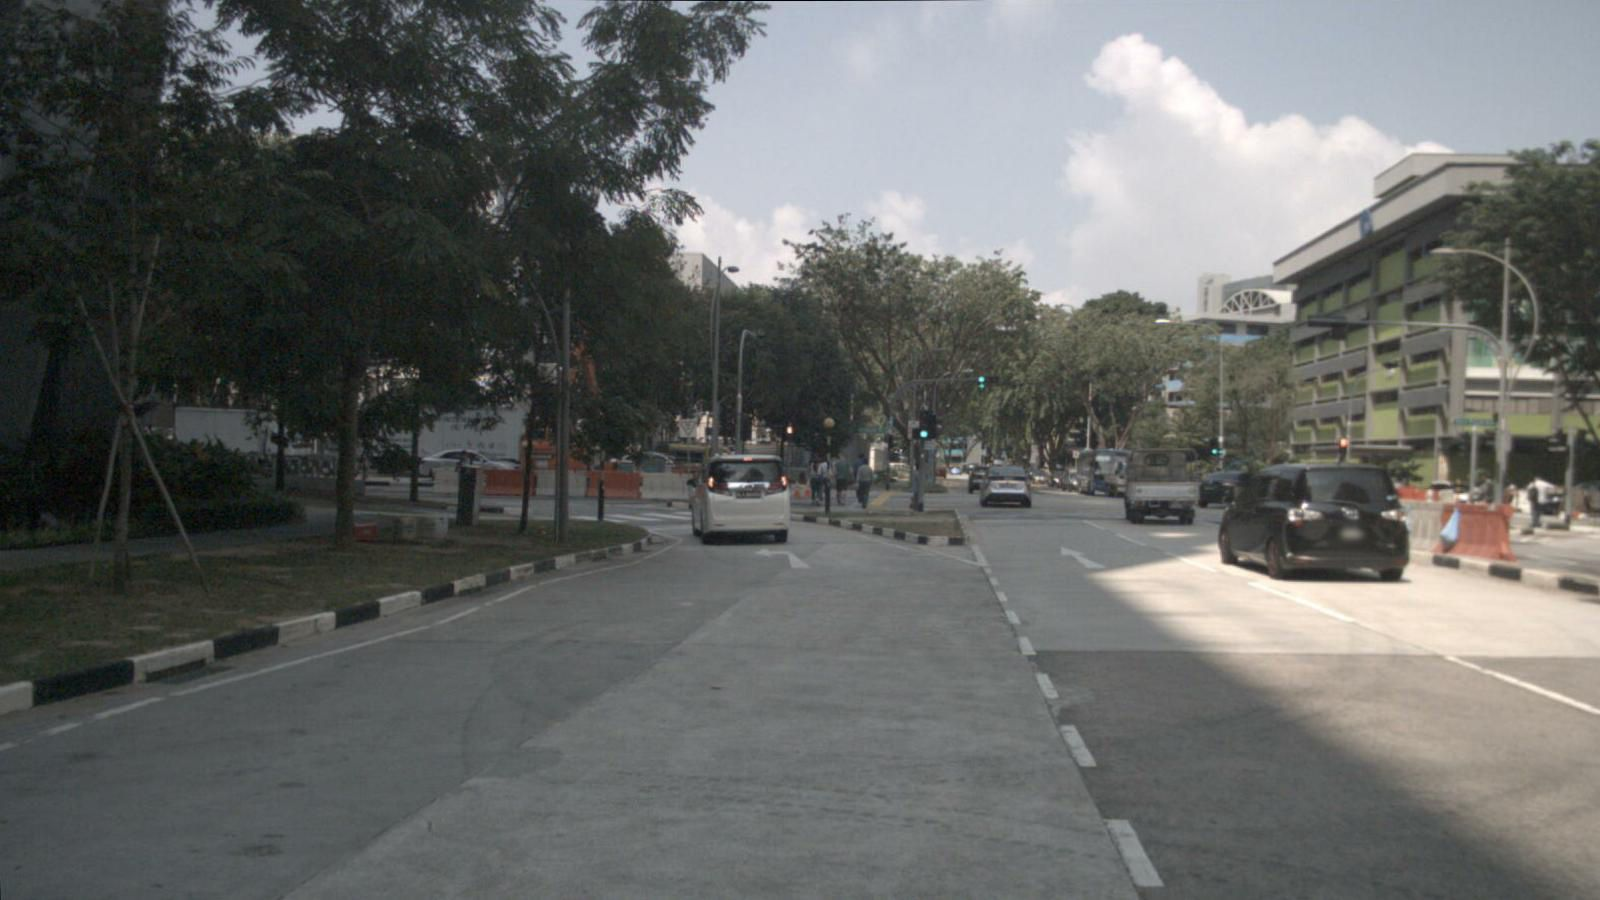

In [96]:
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
current_image_path = PATH+"/"+cam_front_data['filename']
img = Image.open(current_image_path)
image_tensor = transform(img)
image_tensor = image_tensor.view(1, 3, 70, 320)
IPImage(filename=current_image_path) 

In [97]:
closest_can = get_closest_can(my_sample['timestamp'], my_scene_vehicle_monitor_can)
normalize_vehicle_monitor_can(closest_can)

{'brake': 0.0, 'steering': 0.0, 'throttle': 0.0}

In [98]:
model(image_tensor)

tensor([[-0.0090,  0.0036, -0.0049]], grad_fn=<AddmmBackward0>)

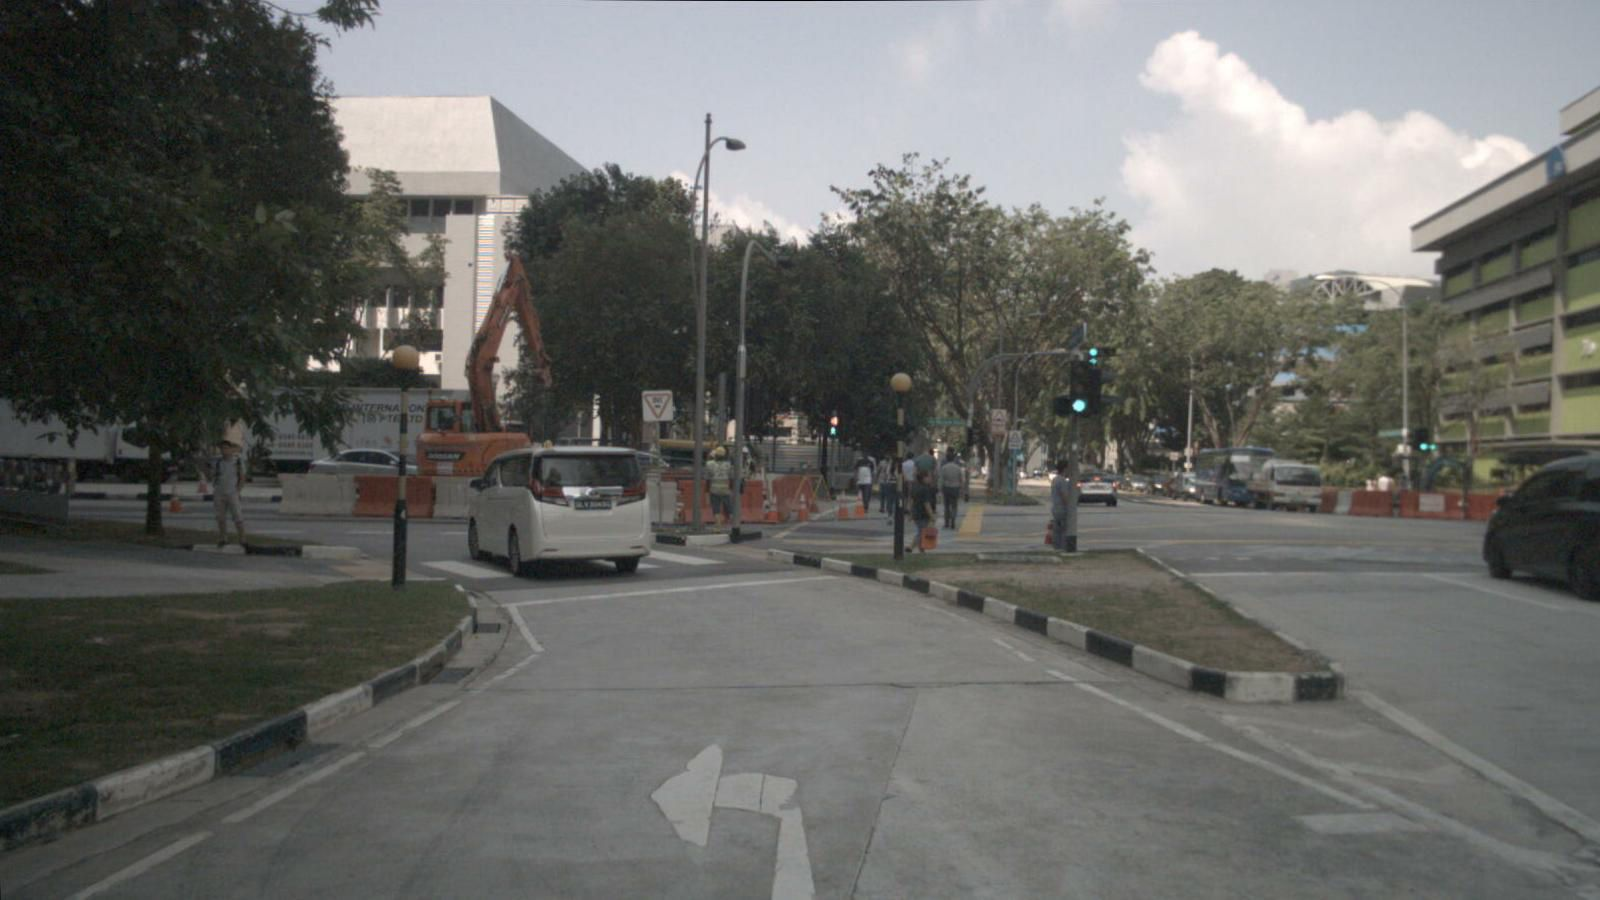

In [99]:
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
my_sample = nusc.get('sample', my_sample['next'])
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
current_image_path = PATH+"/"+cam_front_data['filename']
img = Image.open(current_image_path)
image_tensor = transform(img)
image_tensor = image_tensor.view(1, 3, 70, 320)
IPImage(filename=current_image_path) 

In [100]:
closest_can = get_closest_can(my_sample['timestamp'], my_scene_vehicle_monitor_can)
normalize_vehicle_monitor_can(closest_can)

{'brake': 0.0, 'steering': 0.0, 'throttle': 0.0}

In [101]:
model(image_tensor)

tensor([[-0.0084,  0.0033, -0.0043]], grad_fn=<AddmmBackward0>)